<a href="https://colab.research.google.com/github/dvirbublil02/FinalProject/blob/main/Analyzing_article's.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Clone the GitHub Repository**
**To proceed, we need to clone the GitHub repository containing the required code and resources.**



In [1]:
!rm -rf FinalProject
!git clone https://github.com/dvirbublil02/FinalProject.git



Cloning into 'FinalProject'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 336 (delta 57), reused 85 (delta 36), pack-reused 221 (from 2)
Receiving objects: 100% (336/336), 123.88 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (99/99), done.


# **Step2: Set the Working Directory**
**Change the current working directory to the folder containing the code. This ensures that all subsequent commands are executed in the correct context.**

In [12]:
%cd "/content/FinalProject/‏‏Capstone Project Phase B/Code/"



/content/FinalProject/‏‏Capstone Project Phase B/Code


# **Step3:Run the prepare_data.py Script**
**Execute the prepare_data.py script to preprocess the dataset (e.g., PubMed) and generate snapshots by dividing the data into manageable segments , and creating the dynamic grpah with injected anomalies.**

**Estimated Runtime: Approximately  10 - 15 minutes, depending on the GPU performance.
Purpose: This step handles dataset preprocessing and snapshot creation, preparing the data for subsequent analysis.**

In [7]:
!python prepare_data.py

Generating data with anomaly for Dataset:  PubMed
[#s] generating anomalous dataset...
 2025-01-05 06:51:29.082958
[#s] initial network edge percent: #.1f##, anomaly percent: #.1f##.
 2025-01-05 06:51:29.082992 50.0 1.0
Anomaly Generation finish! Time: 227.07 s
Train size:22162  4  Test size:22383 4
Anomalous edges saved to data/OurResearch/anomalous_fake_edges.txt
Training dataset contruction finish! Time: 0.07 s
Test dataset finish constructing! Time: 0.00 s
Saving training snapshot: results/snapshots/train/PubMed_0000_train_0.01.txt
Saving training snapshot: results/snapshots/train/PubMed_0001_train_0.01.txt
Saving training snapshot: results/snapshots/train/PubMed_0002_train_0.01.txt
Saving training snapshot: results/snapshots/train/PubMed_0003_train_0.01.txt
Saving testing snapshot: results/snapshots/test/PubMed_0000_test_0.01.txt
Saving testing snapshot: results/snapshots/test/PubMed_0001_test_0.01.txt
Saving testing snapshot: results/snapshots/test/PubMed_0002_test_0.01.txt
Savin

# **Step 4: Run the train.py Script with our dataset and anomalies ratio.**
**Execute the train.py script to train the model, including the implementation of the anomaly detection logic. This step will also save the anomalous edges for use in subsequent steps.**

 **Purpose: The script trains the model on the prepared data and identifies anomalous edges, storing them for further processing.
 Estimated Runtime: Varies based on the dataset and hardware.(minimum requirement run with 100 gpu power.**


In [4]:
!python train.py --dataset PubMed --anomaly_per 0.01

2025-01-05 06:19:21.804855: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 06:19:21.822989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 06:19:21.843789: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 06:19:21.850068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 06:19:21.865424: I tensorflow/core/platform/cpu_feature_guar

# **Step5:Step 5: Run the visual.py & create_and_save_snapshots.py Script and Generate Visuals and save "screenshots" of the graph**
**This will load the necessary Python files to generate research plots and the anomalous matrix, which can be displayed for analysis.**

**Purpose: This step extracts the anomalous articles from the detected anomalous edges using the implemented logic, and then visualizes the results through plots and matrices.
Outcome: Research plots and the anomalous matrix will be generated and saved for further examination.**

In [5]:
!python visual.py

Anomalies per category plot saved to results/anomalies_per_category.png
Anomaly status matrix saved to results/anomaly_status_matrix.txt
Anomalies by year pair plot saved to results/anomalies_by_year_pair.png
Anomalies per snapshot plot saved to results/anomalies_per_snapshot.png
Anomalies per category plot saved to results/anomalies_per_category.png


In [8]:
!python create_and_save_snapshots.py

Processing file: PubMed_0003_train_0.01.txt with 4762 edges.
Saved 10 snapshots.
Final snapshot of all edges saved as 'snapshots/combined/final_snapshot_all_edges.png'.
Combined snapshots with final snapshot saved as 'snapshots/combined/combined_PubMed_0003_train_0.01.txt.png'.
Completed combining snapshots for PubMed_0003_train_0.01.txt.
Processing file: PubMed_0002_train_0.01.txt with 5800 edges.
Saved 12 snapshots.
Final snapshot of all edges saved as 'snapshots/combined/final_snapshot_all_edges.png'.
Combined snapshots with final snapshot saved as 'snapshots/combined/combined_PubMed_0002_train_0.01.txt.png'.
Completed combining snapshots for PubMed_0002_train_0.01.txt.
Processing file: PubMed_0001_train_0.01.txt with 5800 edges.
Saved 12 snapshots.
Final snapshot of all edges saved as 'snapshots/combined/final_snapshot_all_edges.png'.
Combined snapshots with final snapshot saved as 'snapshots/combined/combined_PubMed_0001_train_0.01.txt.png'.
Completed combining snapshots for PubMe

# **Step 6: Run the visualArticles.py Script**
**Execute the visualArticles.py script to track the anomalous articles over time. This step will visualize how the identified anomalous articles evolve throughout the dataset.**

**Purpose: This visualization will help in understanding the behavior and evolution of anomalous articles over time.
Outcome: A timeline-based visualization will be generated, showing how the anomalous articles change or persist through different time intervals.**



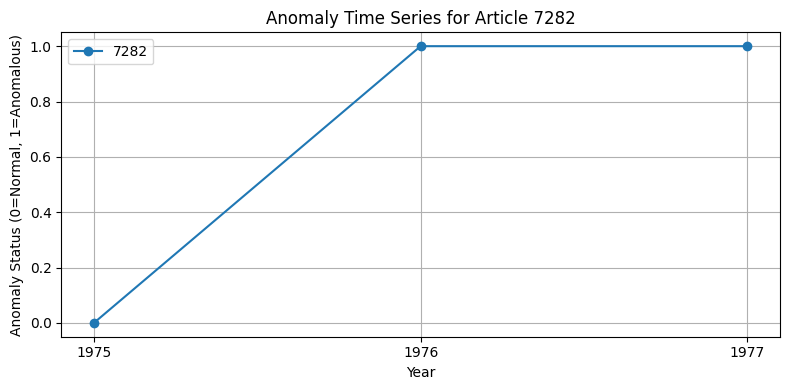

Dropdown(description='Select Article:', index=367, options=(('10000 - A new method for the determination of al…

In [9]:
%run visualArtcles.py

# **Step 7: Run Model Testing**
**Execute the testing process to evaluate the performance of the trained model. This step will test the model’s accuracy and effectiveness in identifying anomalies based on the preprocessed data.
Purpose: To assess the model’s performance and validate its anomaly detection capabilities.
Outcome: Testing results will provide insights into the model’s accuracy and the detection of anomalies.**


In [10]:
%run "/content/FinalProject/‏‏Capstone Project Phase B/Code/tests/tests_preprocessing.py"
%run "/content/FinalProject/‏‏Capstone Project Phase B/Code/tests/tests_model.py"

.../content/FinalProject/‏‏Capstone Project Phase B/Code/codes/DynamicDatasetLoader.py:85: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  return sparse.FloatTensor(indices, values, shape)
.

Dataset loading functionality tested successfully. Test Passed
Row normalization of the sparse matrix tested successfully. Test Passed
Symmetrical normalization of adjacency matrix tested successfully. Test Passed
Conversion of sparse matrix to torch sparse tensor tested successfully. Test passed
Preprocess dataset: PubMed
Data failed to load. Test Passed: Raw file was not found, as expected.


.

structure of generateDataset function including generate anoamlies and inject them verified successfully! Test Passed


.

Raw file absolute path: /content/FinalProject/‏‏Capstone Project Phase B/Code/data/raw/processed_pubmed.txt
Preprocess dataset: PubMed


.
----------------------------------------------------------------------
Ran 7 tests in 2.404s

OK


vertex: 19717  edge: 44324
Preprocess finished! Time: 0.31 s
Data successfully loaded and processed. Test Passed


.....
----------------------------------------------------------------------
Ran 5 tests in 0.054s

OK


Snapshot 1 saved anomalous edges: [(0, 2), (3, 4)]
Snapshot 2 saved anomalous edges: [(1, 3)]
Snapshot 3 saved anomalous edges: [(2, 4), (0, 1)]
Test completed successfully.
AUC for each snapshot:
Snapshot 1 AUC: 1.0
Snapshot 2 AUC: 1.0
Snapshot 3 AUC: 1.0
Full AUC: 1.0

All tests passed! Time: 0.008s
Model evaluation and AUC calculation verified successfully. test pass
Model Initialization Test Passed!
Negative edges successfully checked and verified Test passed!
Snapshot 1 saved edge embeddings: [[0.1 0.2]
 [0.3 0.4]]
Snapshot 2 saved edge embeddings: [[0.5 0.6]
 [0.7 0.8]]
Snapshot 3 saved edge embeddings: [[0.9 1. ]
 [1.1 1.2]]
test_save_edge_embeddings passed successfully.
Training Hyperparameters Test Passed!


<Figure size 640x480 with 0 Axes>

# **Step 8: (Optional) Download the Results**
**If you wish to download the results generated during the process, you can use the following command to save them locally.
Purpose: This step allows you to download any generated files, such as research plots, anomalous data matrices, or test results, for further analysis or presentation.
Outcome: The specified files will be downloaded to your local machine.**




In [15]:
import os
import shutil
from zipfile import ZipFile
from google.colab import files

# Define base directory
base_dir = "/content/FinalProject/‏‏Capstone Project Phase B/Code/"

# Define the folders you want to include in the zip
folders = [
    os.path.join(base_dir, "results"),
    os.path.join(base_dir, "snapshots"),
    os.path.join(base_dir, "data/OurResearch")
]

# Define files to exclude from the snapshots folder
exclude_files = [
    f"snapshot_{i}.png" for i in range(1, 13)
] + ["final_snapshot_all_edges.png"]

# Ensure the folders exist
for folder_path in folders:
    if not os.path.exists(folder_path):
        print(f"Creating folder: {folder_path}")
        os.makedirs(folder_path, exist_ok=True)

# Create a single zip file containing all the folders
zip_name = "capstone_b_results.zip"
with ZipFile(zip_name, 'w') as zipf:
    for folder_path in folders:
        if os.path.exists(folder_path):
            for root, _, files_list in os.walk(folder_path):
                for file_name in files_list:
                    # Skip excluded files if in the snapshots folder
                    if (
                        folder_path.endswith("snapshots")
                        and file_name in exclude_files
                    ):
                        continue
                    # Create the path inside the zip file
                    file_path = os.path.join(root, file_name)
                    arcname = os.path.relpath(file_path, base_dir)
                    zipf.write(file_path, arcname)
        else:
            print(f"Folder not found: {folder_path}")

# Download the zip file
files.download(zip_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>